### BOAZ 엔지니어 세션 
2022.10.12 우아라

In [ ]:
!pip install pyspark
!pip install -q findspark

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local").appName("learn-sql").getOrCreate()

import findspark
findspark.init()

spark.version

**Scikits learn**  
   - 단일 서버에서만 머신러닝 알고리즘이 구동될 수 있도록 구현 

**Spark MLlib**   
   - 분산서버에서 머신러닝 알고리즘이 구동될 수 있도록 구현  

**Spark ML classification(분류) 지원 클래스**  
- 로지스틱 회귀(LogisticRegression)  
- 결정트리(DecisionTreeClassifier)  
- 랜덤 포레스트(RandomForestClassifier)  
- 그래디언트 부스팅(GBTClassifier) -> 현재 Spark 버전 기준으로 binary classification만 가능  
- XGBoost(XGBoostClassifier)  
- LightGBM(LightGBMClassifier)  
- 나이브베이츠(NaiveBayes)  
- 서포트 벡터 머신(LinearSVC) 

#### Iris 데이터 세트를 Spark DataFrame으로 로드

In [ ]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np

# iris 데이터 세트 로딩
iris = load_iris()
iris_data = iris.data
iris_label = iris.target

# iris dataframe을  numpy에서 pandas DataFrame으로 변환 
iris_columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
iris_pdf = pd.DataFrame(iris_data, columns=iris_columns)    
iris_pdf['label'] = iris_label

# pandas DataFrame을 spark DataFrame으로 변환
iris_sdf = spark.createDataFrame(iris_pdf)

iris_sdf.limit(10).show()

In [ ]:
from pyspark.sql.functions import count, isnan, when, col

# iris_sdf schema 확인
print(iris_sdf.printSchema())

# iris_sdf에서 Null값이 있는 컬럼 확인
iris_sdf.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in iris_sdf.columns]).show()

In [ ]:
iris_sdf.describe().show()

In [ ]:
# label 값별 건수 조사
iris_sdf.groupBy('label').count().show()

In [ ]:
from pyspark.ml.feature import VectorAssembler, VectorIndexer

# feature 컬럼들을 vectorization 적용. 
vectorAssembler = VectorAssembler(inputCols=iris_columns, outputCol="features")
vectorized_sdf = vectorAssembler.transform(iris_sdf)

# vectorized된 DataFrame을 학습 데이터와 테스트 데이터로 분리 
train_sdf, test_sdf = vectorized_sdf.randomSplit([0.8, 0.2], seed=2021)

### Decision Tree로 학습, 예측

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

# feature과 label로 어떤 것이 사용될 지 반드시 지정
dt_classifier = DecisionTreeClassifier(featuresCol='features', labelCol='label'
                                      , maxDepth=4, minInstancesPerNode=5)
# model이 반환되고,
dt_model = dt_classifier.fit(train_sdf) 

# 반환된 model에서 prediction이 진행됨
dt_predictions = dt_model.transform(test_sdf)

In [ ]:
print(type(dt_model))

In [ ]:
# 기존의 column 들과, feature vectorized 된 컬럼이 추가되어 출력
dt_predictions.show()

In [ ]:
# doc이 길어서 보기 불편
dt_classifier.extractParamMap()

In [ ]:
# 보기 힘든 앞의 코드를 한번 정리한 코드
# estimator 클래스가 가지는 parameter들. hyper parameter와 로직 구성을 위한 다른 parameter들을 함께 가지고 있음. 
dt_param_names = [(param_key.name, value) for param_key, value in dt_classifier.extractParamMap().items()]
dt_param_names

In [ ]:
print('feature 갯수:', dt_model.numFeatures, 'class 갯수:', dt_model.numClasses, 'label column명:', dt_model.getLabelCol())
print('결정트리 노드 갯수:', dt_model.numNodes, '결정트리 깊이:', dt_model.depth)
print('결정트리 피처 중요도:', dt_model.featureImportances) # 특정 feature가 트리를 분할하는데 얼마나 기여를 했는지에 따라 중요도, sparse vector로 출력됨

# +) 4,[2,3] : 4개의 노드가 있는데, [2,3]번째 (3,4번째) feature만 importance 하겠다.

In [ ]:
from pyspark.ml.linalg import DenseVector

print('dt_model.featureImportance 결과 type:', type(dt_model.featureImportances))
dt_ftr_importances = DenseVector(dt_model.featureImportances)
print('Dense Vector 변환 후 type과 값:', type(dt_ftr_importances), dt_ftr_importances)

In [ ]:
# 만들어진 dense vector을 시각화하기 쉽게 List로 바꿈
dt_ftr_importances_list = list(dt_ftr_importances)
for name, value in zip(iris_sdf.columns, dt_ftr_importances_list):
    print('name:', name, 'value:', value)

In [ ]:
iris_columns

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(x=dt_ftr_importances_list, y=iris_columns)
plt.show()

### Random Forest로 학습, 예측

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf_classifier = RandomForestClassifier(featuresCol='features', labelCol='label'
                                       , maxDepth=4, numTrees=100)
rf_model = rf_classifier.fit(train_sdf)
rf_predictions = rf_model.transform(test_sdf)

In [ ]:
# 파라미터의 이름, 값 출력
rf_params = [(param.name, value) for param, value in rf_classifier.extractParamMap().items()]
rf_params

In [ ]:
from pyspark.ml.linalg import DenseVector
import matplotlib.pyplot as plt
import seaborn as sns

rf_ftr_importances_list = list(DenseVector(rf_model.featureImportances))

sns.barplot(x=rf_ftr_importances_list, y=iris_columns)
plt.show()

### Gradient Boosting으로 학습, 예측
* GBTClassifier는 Spark 3.3 기준으로 binary classification만 지원하므로 아래는 오류를 발생함

In [ ]:
from pyspark.ml.classification import GBTClassifier

gbt_classifier = GBTClassifier(featuresCol='features', labelCol='label' 
                                       , maxDepth=4, maxIter=30)
# GBTClassifier는 Spark 3.2 기준으로 binary classification만 지원하므로 아래는 오류를 발생함
gbt_model = gbt_classifier.fit(train_sdf)
gbt_predictions = gbt_model.transform(test_sdf)

'''
"An error occurred while calling {0}{1}{2}.\n".
label의 값이 0,1만 있는게 아니라서 오류 발생.
다른 classifier 들과 개념은 같으므로 이런 방법이 있다는 것만 알아두면 좋을 것 같습니다.
'''

In [ ]:
[param.name for param in gbt_classifier.params]

### 위스콘신 암 데이터 세트로 RandomForest, GBT 모델 학습, 예측

In [ ]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np

# 위스콘신 cancer 데이터 세트를 사이킷런에서 로딩하고 pandas DataFrame으로 변환. 
cancer = load_breast_cancer()
cancer_features = cancer.data
cancer_label = cancer.target
cancer_columns = cancer.feature_names

cancer_pdf = pd.DataFrame(cancer_features, columns=cancer_columns)
cancer_pdf['label'] = cancer_label

# pandas DataFrame을 spark DataFrame으로 변환.
cancer_sdf = spark.createDataFrame(cancer_pdf)
cancer_sdf.limit(10).show()

In [ ]:
from pyspark.sql.functions import count, isnan, when, col

# cancer_sdf의 schema 확인
print(cancer_sdf.printSchema())

# cancer_sdf에서 Null값이 있는 컬럼 확인
(cancer_sdf.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in cancer_sdf.columns])).show()

In [ ]:
# label 값별 건수 조사
(cancer_sdf.groupBy('label').count()).show()

### 위스콘신 데이터를 학습과 테스트용으로 분리하고 RandomForest, GBT 분류 적용.

In [ ]:
from pyspark.ml.feature import VectorAssembler, VectorIndexer

# feature 컬럼들을 vectorization 적용. 
vectorAssembler = VectorAssembler(inputCols=cancer_columns, outputCol="features")
vectorized_sdf = vectorAssembler.transform(cancer_sdf)

# vectorized된 DataFrame을 학습 데이터와 테스트 데이터로 분리 
train_sdf, test_sdf = vectorized_sdf.randomSplit([0.8, 0.2], seed=2021)

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf_classifier = RandomForestClassifier(featuresCol='features', labelCol='label', maxDepth=4, numTrees=100)
rf_model = rf_classifier.fit(train_sdf)
rf_predictions = rf_model.transform(test_sdf)

In [ ]:
(rf_predictions.limit(10)).show()

In [ ]:
# binary classicication을 진행중이지만, MulticlassClassificationEvaluator을 사용
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator_accuracy = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
print('Random Forest 정확도:', evaluator_accuracy.evaluate(rf_predictions))

In [ ]:
from pyspark.ml.classification import GBTClassifier

gbt_classifier = GBTClassifier(featuresCol='features', labelCol='label'
                                       , maxDepth=4, maxIter=30)
gbt_model = gbt_classifier.fit(train_sdf)
gbt_predictions = gbt_model.transform(test_sdf)

print('GBT 정확도:', evaluator_accuracy.evaluate(gbt_predictions))

### Evaluation
* BinaryClassificationEvaluator, MulticlassClassificationEvaluator 두개의 클래스를 이용하여 성능 평가  
(ex). Binary : 암o, 암x (0 or 1)  
(ex). Multi : iris 데이터셋처럼 품종을 파악하는 등 2개의 클래스 이상   

* 이진 분류, 멀티 클래스 분류 구분과 클래스 이름과 정확히 매핑되지 않음. 적용시 착각을 일으킬 수 있음. 
* BinaryClassificationEvaluator는 roc-auc 지표만 제공. 
* 정확도(accuracy)를 얻기 위해서는 이진분류 여부와 관계없이 MulticlassClassificationEvaluator 클래스를 사용해야 함. 
* precision, recall, f1-score를 얻기 위해서는 이진분류 여부와 관계없이 MulticlassClassificationEvaluator 클래스를 사용해야 함. 
* MulticlassClassificationEvaluator로 얻어지는 precision, recall은 weighted precision, weighted recall 값임.
* 편리함을 위해서라면 예측 결과 Spark DataFrame을 pandas DataFrame으로 변경하고 사이킷런 평가 API를 사용하는 것이 더 나은 선택일 수 있음.

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator_precision = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='weightedPrecision')
evaluator_recall = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='weightedRecall')
evaluator_f1_score = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')

In [ ]:
print('Random Forest 정밀도(precision):', evaluator_precision.evaluate(rf_predictions))
print('Random Forest 재현율(recall):', evaluator_recall.evaluate(rf_predictions))
print('Random Forest f1 score:', evaluator_f1_score.evaluate(rf_predictions))

In [ ]:
# pandas의 dataframe으로 바꿔서 sklearn에서는 어떻게 평가하는지 보기
rf_predictions_pdf = rf_predictions.select('label', 'prediction').toPandas()
rf_predictions_pdf.head(10)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

sk_precision = precision_score(rf_predictions_pdf['label'], rf_predictions_pdf['prediction'])
sk_recall = recall_score(rf_predictions_pdf['label'], rf_predictions_pdf['prediction'])
sk_f1_score = f1_score(rf_predictions_pdf['label'], rf_predictions_pdf['prediction'])

sk_precision_weighted = precision_score(rf_predictions_pdf['label'], rf_predictions_pdf['prediction'], average='weighted')
sk_recall_weighted = recall_score(rf_predictions_pdf['label'], rf_predictions_pdf['prediction'], average='weighted')
sk_f1_score_weighted = f1_score(rf_predictions_pdf['label'], rf_predictions_pdf['prediction'], average='weighted')

print('precision by sklearn:', sk_precision)
print('recall by sklearn:', sk_recall)
print('f1 score by sklearn:', sk_f1_score)
print('===== weighted =====')
print('weighted precision by sklearn:', sk_precision_weighted)
print('weighted recall by sklearn:', sk_recall_weighted)
print('weighted f1 score by sklearn:', sk_f1_score_weighted)

# -> weighted 를 적용해야 동일한 계산이 되는 것을 알 수 있음

- 일반적인 precision, recall 계산 방식  


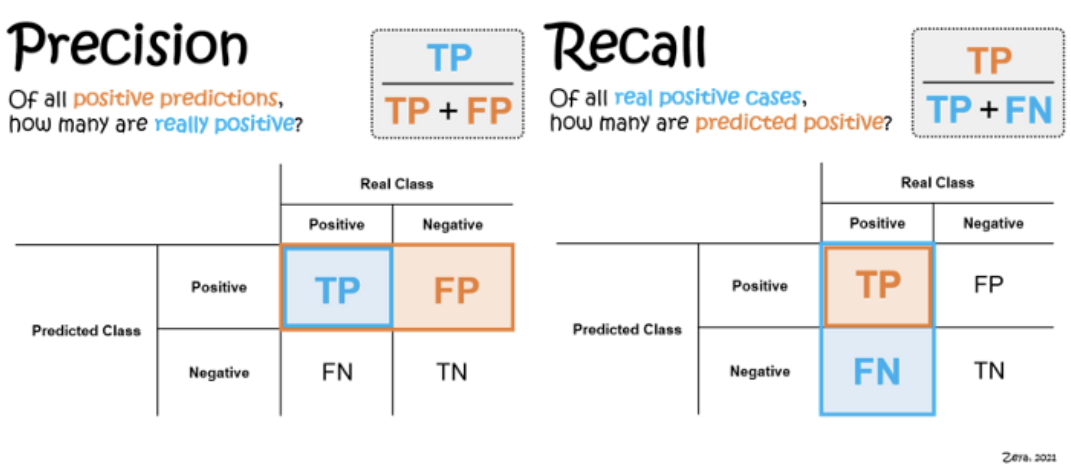


- spark에서는 positive 의 건수를 weighted로 공식에 반영해서 계산값이 달라지게 됨  
(https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html 참고)
